In [4]:
import re
import warnings
import pandas as pd
import numpy as np
from Bio import PDB
import torch

# from Bio.PDB import PDBList
import Bio.PDB.PDBParser as PDBParser
import Bio.PDB.PDBList as PDBList
import networkx as nx
# import torch_geometric
# import torch_geometric.utils
import pickle 
import os

In [2]:
from struc_feat import create_protein_graph

look at ego label subgraphs, with 70% or more overlap (from ProteinRPN)

In [3]:
pdb_path = "/Users/robsonlab/Teetly/AFEnzymeRelax/test/relax/A0A009IHW8_relaxed_0001.pdb"
#add in a csv active and binding site list processor later on, or name these pdb files accordingly
#ASSUME THAT THESE SITE LABELS ARE FROM THE COUNT OF 1 (NOT FROM 0)
functional_nodes = [4, 5, 6, 8, 9, 10,11, 15, 164, 168, 170]
graph  = create_protein_graph(pdb_path, functional_nodes)
# from model import triplets
# print(triplets(graph.edges, len(graph.nodes)))

In [4]:
print(graph.nodes.data())

[(0, {'y': 0, 'x': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0.]), 'dssp': 'None', 'ca_coords': array([ 44.995,   3.816, -34.382], dtype=float32), 'angle_geom': array([[-0.5909056 , -0.10790762, -0.7994914 ],
       [ 0.1238667 , -0.99139863,  0.0422593 ],
       [-0.79717475, -0.0740591 ,  0.59918916]], dtype=float32)}), (1, {'y': 0, 'x': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.]), 'dssp': 'None', 'ca_coords': array([ 46.229,   0.526, -32.781], dtype=float32), 'angle_geom': array([[-0.38473517, -0.7226304 , -0.57426834],
       [ 0.4248523 , -0.6909744 ,  0.58485454],
       [-0.81943846, -0.0189651 ,  0.5728534 ]], dtype=float32)}), (2, {'y': 0, 'x': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.]), 'dssp': 'None', 'ca_coords': array([ 49.631,   0.3  , -30.976], dtype=float32), 'angle_geom': array([[ 3.9290249e-02, -

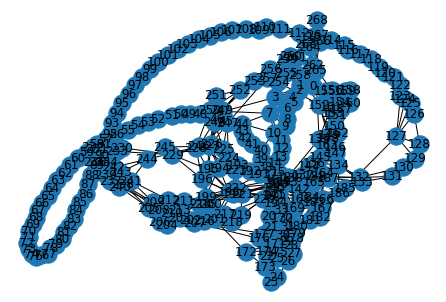

In [29]:
nx.draw(graph, with_labels=True)
#a look only a mother can love

In [5]:
#NEEDS TESTING
"""Adds functionality labels for the ego graph anchor centered at each functional node IF 

    >70% of a functional site (what is within 10 angsstroms of that node) is within the ego graph

    Args:
        protein_graph (nx.Graph): takes in protein graph processed by create_protein_graph()
        radius = 2 (int): radius of ego graph
        overlap_ratio_cutoff = 0.9 (float): ratio of functional nodes within 10 angstroms of a functional node that must be in ego graph for ego label to be 1

    Returns:
        label_graphs (dict): for each (ground truth = 1) functional node, what are the ground truth graph pdbsites
        graph is directly edited in-place to include ego_label attribute
    """
def ego_label_set(graph: nx.Graph, sites: list, radius = 2, overlap_ratio_cutoff = 0.9):
    ego_label = {node: 0 for node, att in graph.nodes(data=True)}
    label_graphs = (
        {}
    )  # for each (ground truth = 1) functional node what are the ground truth graph pdbsites
    functional_nodes = [
        node for node, att in graph.nodes(data=True) if att["y"] == 1
    ]
    for functional_node in functional_nodes:
        ego_subgraph = nx.ego_graph(graph, functional_node, radius=radius)
        #count number of functional nodes in ego subgraph
        func_subgraph_nodes = len([
            node for node, att in ego_subgraph.nodes(data=True) if att["y"] == 1
        ])
        #now find number of functional nodes within 10 angstroms of functional node
        #extract site nodes numbers, and compute distances
        total_func_nodes_ten_apart = len([
            node for node in sites if nx.shortest_path_length(graph, source=functional_node, target=node, weight='distance') <= 10
        ])
        #if this functional node has at least [overlap_ratio_cutoff] of the functional nodes within 10 angstroms of it, give it an ego label of 1 and add it
        #to label_graphs dictionary
        if func_subgraph_nodes / total_func_nodes_ten_apart > overlap_ratio_cutoff:
            ego_label[functional_node] = 1
            label_graphs[functional_node] = ego_subgraph
    nx.set_node_attributes(graph, ego_label, "ego_label")
    return label_graphs

In [6]:
print(ego_label_set(graph, functional_nodes))

{8: <networkx.classes.graph.Graph object at 0x155512b92f50>, 9: <networkx.classes.graph.Graph object at 0x155550d7a9d0>, 10: <networkx.classes.graph.Graph object at 0x155512bb2710>, 11: <networkx.classes.graph.Graph object at 0x155512b92250>, 168: <networkx.classes.graph.Graph object at 0x155512bbc250>}


ADJACENCY MATRIX ON EDGES, TRIPLET AND GEOMETRY INTEGRATION

In [10]:
from torch_sparse import SparseTensor
from torch_geometric.nn import radius_graph

In [11]:
def triplets(edge_index, num_nodes):
    edge_index = torch.tensor(list(edge_index)).t().contiguous()
    row, col = edge_index  # j->i
    value = torch.arange(row.size(0), device=row.device)
    adj_t = SparseTensor(row=col, col=row, value=value,
                            sparse_sizes=(num_nodes, num_nodes))
    adj_t_row = adj_t[row]
    num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

    # Node indices (k->j->i) for triplets.
    idx_i = col.repeat_interleave(num_triplets)
    idx_j = row.repeat_interleave(num_triplets)
    idx_k = adj_t_row.storage.col()
    mask = idx_i != idx_k  # Remove i == k triplets.
    idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

    # Edge indices (k-j, j->i) for triplets.
    idx_kj = adj_t_row.storage.value()[mask]
    idx_ji = adj_t_row.storage.row()[mask]
    return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji

In [12]:
#possible forward for internaction block
pos = torch.tensor([att["ca_coords"] for node, att in graph.nodes(data=True)])
i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = triplets(
            graph.edges, num_nodes=len(graph.nodes))
# Calculate distances.
dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

In [13]:
# Calculate angles.
pos_i = pos[idx_i]
pos_ji, pos_ki = pos[idx_j] - pos_i, pos[idx_k] - pos_i
a = (pos_ji * pos_ki).sum(dim=-1)
b = torch.cross(pos_ji, pos_ki).norm(dim=-1)
angle = torch.atan2(b, a)

In [74]:
init_xyz = pos.reshape(len(graph.nodes), 1, 3)

In [69]:
#not quite the rbf I'd want, probably

def rbf(D):
    # Distance radial basis function
    D_min, D_max, D_count = 0., 20., 6
    D_mu = torch.linspace(D_min, D_max, D_count).to(D.device)
    D_mu = D_mu[None,:]
    D_sigma = (D_max - D_min) / D_count
    D_expand = torch.unsqueeze(D, -1)
    RBF = torch.exp(-((D_expand - D_mu) / D_sigma)**2)
    return RBF

In [77]:
rbf_feat = rbf(torch.cdist(init_xyz[:,0,:], init_xyz[:,0,:]))

In [40]:
rbf_emb = rbf(dist)

In [41]:
#the final concatenation is of each 
from torch_geometric.nn.models.dimenet import EmbeddingBlock
#import lazy linear
from torch.nn import LazyLinear
from torch.nn import Linear

In [86]:
"""
Initialization inputs: number of nodes, number 
"""
class NodeEmbeddingBlock(torch.nn.Module):
    def __init__(self, one_hot_dim, num_nodes, num_radial, hidden_channels, act):
        super().__init__()
        self.act = act

        #self.emb = Embedding(num_atoms, hidden_channels)
        self.emb = Linear(one_hot_dim, hidden_channels)
        self.lin_angle_geom = Linear(3, hidden_channels)
        self.lin_angle_final = LazyLinear(hidden_channels)
        self.lin_rbf = LazyLinear(hidden_channels * 2)
        self.lin = Linear(3 * hidden_channels, hidden_channels)
        self.act = torch.nn.ReLU()
        self.reset_parameters()

    def reset_parameters(self):
        #self.emb.weight.data.uniform_(-sqrt(3), sqrt(3))
        self.lin_rbf.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, x, angle_geom, rbf):
        x = self.emb(x) 
        angle_geom = self.act(self.lin_angle_geom(angle_geom))
        #flatten the last two dimensions together of angle_Geom
        angle_geom = self.lin_angle_final(angle_geom.view(angle_geom.size(0), -1))
        #flatten last two dimensions of rbf
        rbf = rbf.reshape(rbf.size(0), -1)
        rbf = self.lin_rbf(rbf)
        """
        Dimensions: 
        x = (num_nodes, hidden_channels)
        angle_geom = (num_nodes, hidden_channels)
        rbf = (num_nodes, hidden_channels * 2)
        """
        embs = self.act(torch.cat([x, angle_geom, rbf], dim=-1))
        
        return embs

In [87]:
from torch.nn import Linear, ReLU
emb_layer = NodeEmbeddingBlock(
    num_radial=6,
    num_nodes=len(graph.nodes),
    one_hot_dim=22,
    act=ReLU(),
    hidden_channels=32
)

In [51]:
angle_geom = torch.FloatTensor([att["angle_geom"] for node, att in graph.nodes(data=True)])

In [88]:
node_Embs = emb_layer(node_one_hot, angle_geom ,rbf_feat)

In [143]:
#for now, just concatenate these x y z coordinate planes to whatever is permuted from rbf on the node angles and distances from each other...
rbf_emb = rbf(dist)
from torch_geometric.nn.models.dimenet import BesselBasisLayer
rbf_emb = BesselBasisLayer(
    num_radial=6, cutoff=5.0, envelope_exponent=5)
rbf_emb = rbf_emb(dist)

In [144]:
from torch_geometric.nn.models.dimenet import SphericalBasisLayer
sbf_layer = SphericalBasisLayer(
    num_spherical = 7,
    num_radial=6,
    cutoff = 5.0,
    envelope_exponent=5
)

In [145]:
sbf_emb = sbf_layer(dist, angle, idx_kj)

In [147]:
#make sure it is torch tensor 32 bit
node_one_hot = torch.FloatTensor([att["x"] for node, att in graph.nodes(data=True)])

Trying out DimenetDirectly

In [5]:
from dimenetpp import DimeNet
import torch

In [2]:
dimenet_layer = DimeNet(
    num_radial=6,
    num_spherical=7,
    num_bilinear=8,
    hidden_channels=32,
    out_channels=32, 
    num_blocks=1,
    num_classes = 5
)

In [7]:
from struc_feat import create_protein_graph
pdb_path = "/Users/robsonlab/Teetly/AFEnzymeRelax/test/relax/A0A009IHW8_relaxed_0001.pdb"
#add in a csv active and binding site list processor later on, or name these pdb files accordingly
#ASSUME THAT THESE SITE LABELS ARE FROM THE COUNT OF 1 (NOT FROM 0)
functional_nodes = [4, 5, 6, 8, 9, 10,11, 15, 164, 168, 170]
graph  = create_protein_graph(pdb_path, functional_nodes)

In [8]:
node_one_hot = torch.FloatTensor([att["x"] for node, att in graph.nodes(data=True)])
pos = torch.tensor([att["ca_coords"] for node, att in graph.nodes(data=True)])
edge_index = torch.tensor(list(graph.edges)).t().contiguous()

In [ ]:
graph_emb, out = dimenet_layer(
    x = node_one_hot,
    pos = pos,
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
)